In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
%matplotlib inline
plt.style.use("seaborn-talk")

import seaborn as sns
from dateutil import tz
import pytz 
import tqdm

from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

import folium
from branca.element import Figure
from folium.plugins import HeatMapWithTime, HeatMap
from folium.plugins import MarkerCluster

# reading and preprocessing related functions
def read_raw(date):
    """
    Reads in the data. Does not remove any row. 
    """
    if len(str(date[8:])) == 2:
        df_bme = pd.read_csv("data/" + date + "_bme.csv", index_col= 0)
        df_gps = pd.read_csv("data/" + date + "_gps.csv", index_col = 0)
        df_pol = pd.read_csv("data/" + date + "_pol.csv", index_col = 0)
    else:
        df_bme = pd.read_csv("data/" + date + "_bme.csv", index_col= 0)
        df_gps = pd.read_csv("data/" + date + "_gps.csv", index_col = 0)
        df_pol = pd.read_csv("data/" + date + "_pol.csv", index_col = 0)
    return df_bme, df_gps, df_pol

def handle_dateTime(df_all):
    ## change dateTime column from type "object" to "datetime"
    df_all["dateTime"] = pd.to_datetime(df_all.dateTime)    
    # convert to India timing
    to_zone = tz.gettz('Asia/Kolkata')
    df_all.dateTime = df_all.dateTime.apply(lambda x: pytz.utc.localize(x, is_dst=None).astimezone(to_zone))
    return df_all

def make_time_cols(df_all):
    df_all["hour"] = df_all.dateTime.dt.hour
    df_all["minute"] = df_all.dateTime.dt.minute    
    return df_all

def preprocess(df_tuple):
    """
    Combines all other functions
    """
    df_bme, df_gps, df_pol = df_tuple
    
    # drop duplicates
    df_bme = df_bme.drop_duplicates(subset ="uid" )
    df_gps = df_gps.drop_duplicates(subset = "uid")
    df_pol = df_pol.drop_duplicates(subset = "uid")
    
    # merge on key columns
    key_cols = ["uid", "dateTime", "deviceId"]
    df_all = pd.merge(df_bme, df_gps, on = key_cols)
    df_all = pd.merge(df_all, df_pol , on = key_cols)
    
    # rename lng to long and shorten device IDs
    df_all = df_all.rename(columns = {"lng":"long"})
    df_all.deviceId = df_all.deviceId.str[-5:]
    
    # handle dateTime and time related columns
    df_all = handle_dateTime(df_all)
    df_all = make_time_cols(df_all)
    
    # some final stuff 
    df_all = df_all.sort_values("dateTime")
    df_all = df_all.reset_index(drop = True)
    return df_all

# divergence related functions
def plot_prob(data, probs):
    main_set = np.hstack([data, probs])
    main_set = main_set[np.argsort(main_set[:,0], axis = 0)]
    plt.figure(figsize = (6,4))
    plt.xlabel("Index")
    plt.ylabel("Probabilities")
    plt.plot(main_set[:,0], main_set[:,1], "-")
    plt.show()
    
def all_divergence(d1, d2):
    js_div = jensenshannon(d1, d2) ** 2
    kl_12 = entropy(d1, d2)
    kl_21 = entropy(d2, d1)   
    return js_div, kl_12, kl_21
    
def get_divergence(d1, d2, plot = True):
    kde1 = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde1.fit(d1)

    kde2 = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde2.fit(d2)

    all_sets = np.vstack([d1, d2])
    sample = np.linspace(all_sets.min(), all_sets.max(), 1000)[:, None]
    
    prob1 = np.exp(kde1.score_samples(sample))[:, None]
    prob2 = np.exp(kde2.score_samples(sample))[:, None]
    
    prob1 = prob1/np.sum(prob1)
    prob2 = prob2/np.sum(prob2)
     
    if plot:
        print("Probability Distribution learnt by KDE fit on Present Dataset")
        plot_prob(sample, prob1)
        print("Probability Distribution learnt by KDE fit on Previous Datasets")    
        plot_prob(sample, prob2)
    
    return all_divergence(prob1, prob2)

In [7]:
save = False

# Skip All The Below Commented Cells Till You Reach "PlotWise"

---

### Additional Metric: UID Comparison (BME, POL and MERGED)

#### Creating 2 Vertical Plots for ds_3

---

Vedant map 

In [12]:
# valid = valid.sample(1000)

In [14]:
# m.save("../../../Vedant.html")

In [41]:
my_list = []
df =  {'name': ['nick', 'david', 'joe', 'ross'], 
        'age': ['5', '10', '7', '6']}  
df = pd.DataFrame.from_dict(df) 
my_list.append(df.describe())
print(my_list)

[        name age
count      4   4
unique     4   4
top     ross   5
freq       1   1]


----

# PlotWise 

In [42]:
def make_regions(n_splits, dataset_list):
    # regions being made on the basis of both datasets
    both_df = pd.concat(dataset_list, axis = 0)
    lat_min = both_df.lat.min() - 0.00005
    lat_max = both_df.lat.max() + 0.00005
    long_min = both_df.long.min() - 0.00005
    long_max = both_df.long.max() + 0.00005

    bottomLeft = (lat_min, long_min)
    bottomRight = (lat_min, long_max)
    topLeft = (lat_max, long_min)
    topRight = (lat_max, long_max)

    cols = np.linspace(topLeft[1], topRight[1], num=n_splits+1) # lower and upper limits for all columns
    rows = np.linspace(bottomLeft[0], topLeft[0], num=n_splits+1) # lower and upper limits for all rows

    reverse_map = {}
    for i in range(n_splits):
        for j in range(n_splits)[::-1]:
            if (i+j == n_splits-1):
                reverse_map[i] = j

    for ds in dataset_list:
        ds['col'] = np.searchsorted(cols, ds['long'])-1 # "-1" adjusts the indices and makes them start from 0 
        ds['row'] = np.searchsorted(rows, ds['lat'])-1
        ds['row'] = ds['row'].map(reverse_map)
        ds["region"] = n_splits*ds.row + ds.col
    
    return dataset_list

def plot_plotwise(plot_type,start_date=1, end_date=1):
    result = []
    for day_int in range(start_date, end_date+1):    
        dt = "2020-12-" + str(day_int)
        df_bme, df_gps, df_pol = read_raw(dt)
        df_all = preprocess((df_bme, df_gps, df_pol))
        sensor_order = df_all.deviceId.unique()
        sensor_order.sort()

        if plot_type == "ds_1":
            sub = df_all.groupby(["deviceId", "hour", "minute"]).size().reset_index()
            fig, ax = plt.subplots(1, 1, figsize = (15, 5))
#             print(sub.describe())
            print(sub.groupby(["deviceId"])[0].describe())
            result.append(sub.groupby(["deviceId"])[0].describe())
            g = sns.boxplot(y = 0, data = sub, x= "deviceId", order = sensor_order)
            g.set_ylabel("Samples Recorded per Minute")
            g.set_title(str(day_int)+ ": Boxplots for Sampling Rate (Samples Recorded per Minute)")

        elif plot_type == "ds_2":
            sub = df_all.groupby(["deviceId", "hour", "minute"]).size().reset_index()
            sub_2 = sub.groupby(["deviceId", "hour"]).size().reset_index()
            fig, ax = plt.subplots(1, 1, figsize = (15,5))
            g = sns.boxplot(y = 0, data = sub_2, x= "deviceId", order = sensor_order)
            g.set_ylabel("Number of Minutes Active in an Hour")
            g.set_title(str(day_int)+ ": Boxplots for Number of Minutes a Device is Active in an Hour")

        elif plot_type == "ds_3":
            sub_3 = df_all.groupby(["hour", "minute"]).size().reset_index()
            fig, ax = plt.subplots(1, 1, figsize = (15,5))
            ax.set_ylim([0, sub_3[0].max()+5])
            g = sns.boxplot(y = 0, data = sub_3, x= "hour")
            g.set_ylabel("Number of Readings per Minute")
            g.set_title(str(day_int)+ ": Boxplots for Number of Readings per Minute")

        elif plot_type == "ds_4":
            sub = df_all.groupby(["deviceId", "hour", "minute"]).size().reset_index()
            g = sub.groupby("hour").sum()[0].plot(kind="bar", figsize = (15, 5))
            plt.ylabel("Number of Samples/Readings")
            plt.title(str(day_int)+ ": Total Number of Readings per Minute")
            
        elif plot_type == "ds_5":
            df_all.groupby(["deviceId"])["hour"].nunique()[sensor_order].plot(kind = "bar", figsize = (15,5))
            plt.title(str(day_int)+ ": Number of Hours in which data was Recorded")
            plt.ylabel("Number of Hours")
        else:
            invalid = df_all[(df_all.lat<=1) | (df_all.long<=1)].copy()
            valid = df_all[(df_all.lat>1) & (df_all.long>1)].copy()

            if plot_type == "s_1":
                g = (invalid.deviceId.value_counts()[sensor_order]/df_all.deviceId.value_counts()\
                     [sensor_order]).plot(kind = "bar", figsize = (15, 5))
                plt.title(str(day_int) + ": Proportion of Points with Invalid Coordinates (total:{0} / proportion of total observations:{1})".format(\
                                                                                                          invalid.shape[0],\
                                                                                                          invalid.shape[0]/\
                                                                                                          df_all.shape[0]))
                plt.ylabel("Proportion of Points")
                plt.tight_layout()

            elif plot_type == "l_t":
                valid_list = make_regions(4, [valid])
                valid = valid_list[0]
                plt.figure(figsize = (15, 10))
                g = sns.kdeplot(valid.region, valid.hour, cbar=True, shade = True, clip = ((0,15), (0,23)), bw = 0.1, alpha = 0.8)    
                g.set_title(str(day_int)+ ": Bivariate Distribution of Region and Hour", fontsize = 20)
            else:
                valid_p = valid[(valid.pm10 <= 2000) & (valid.pm2_5 <= 2000) & (valid.pm1_0 <=2000)]
                valid_depot = valid_p[valid_p.hour <= 5]
                pm_stats = valid_depot.groupby(["deviceId", "hour", "minute"]).pm2_5.agg(["mean", "std"]).reset_index()
                if plot_type == "pm_1":
                    g = sns.catplot(x = "hour", y = "mean", data = pm_stats, col = "deviceId", aspect = 1,\
                                    col_order = sensor_order, col_wrap = 4, kind = "strip")
                    g.fig.subplots_adjust(top = 0.91, hspace = 0.2)
                    g.fig.suptitle(str(day_int)+ ": Strip Plots for PM2.5 Readings Recorded in Depot", fontsize = 20)
                    g.set_axis_labels("Hour", "Mean PM2.5 Value Observed per Minute")
                    
                elif plot_type == "pm_2":
                    g = sns.catplot(col= "hour", y= "mean", data = pm_stats, col_wrap = 2, height = 6, aspect = 1.5,\
                                    kind= "strip", x = "deviceId", order = sensor_order)
            
                    g.fig.subplots_adjust(top = 0.91, hspace = 0.2)
#                     g.fig.suptitle(str(day_int)+ ": Strip plots for PM2.5 Readings Recorded in Depot", fontsize = 20)
                    g.set_axis_labels("Device ID", "Mean PM2.5 Value Observed per Minute")
                    plt.tight_layout()
                    plt.savefig("../imgs/paper_plots/" + str(dt) + "_inter_sensor.pdf")
                    
                    
        plt.show()
    return result

# Metric Names

### Device Sampling Metrics:
	

		
1. Distribution of Samples Recorded/Collected per Minute
2. Distribution of Number of Minutes each Device was Active in an Hour
3. Aggregated Distribution of Number of Recordings per Minute
4. Aggregated Total Number of Readings per Minute
5. Total Number of Hours Device was Active for
	
### Spatial Metrics:
		
1. Proportion of Points with Invalid Coordinates (lat or long <=1)	
	
### Location and Time
1. Distribution of Regions with Hours
	
### PM 2.5 Metrics
		
1. Intra-Sensor Distribution of PM 2.5 Values at Depot
2. Inter-Sensor Distribution of PM 2.5  Values at Depot

#### Device Sampling Metrics

1) Distribution of Samples Recorded/Collected per Minute

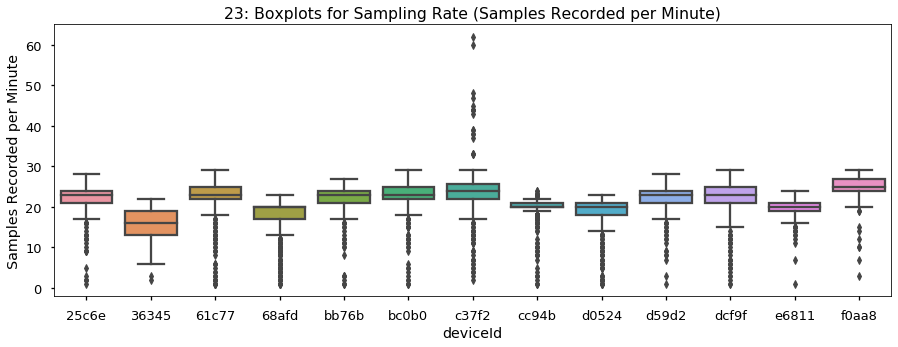

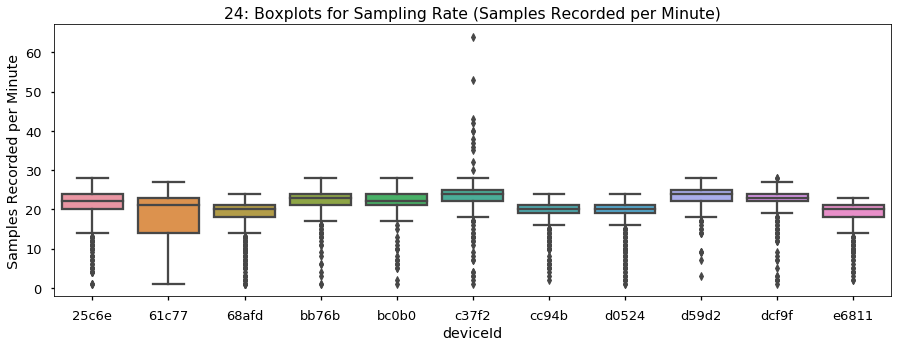

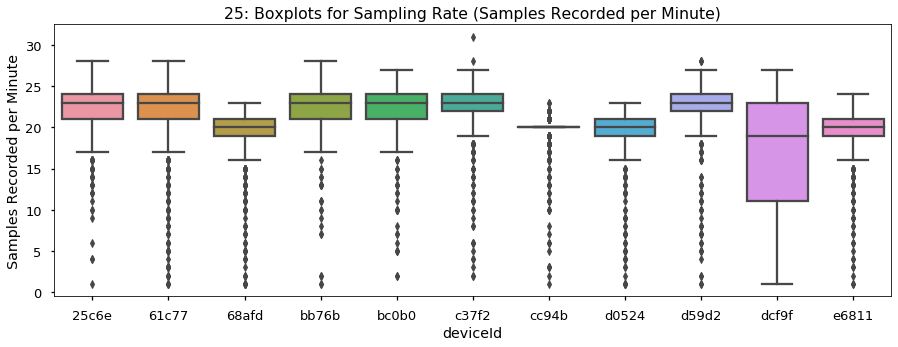

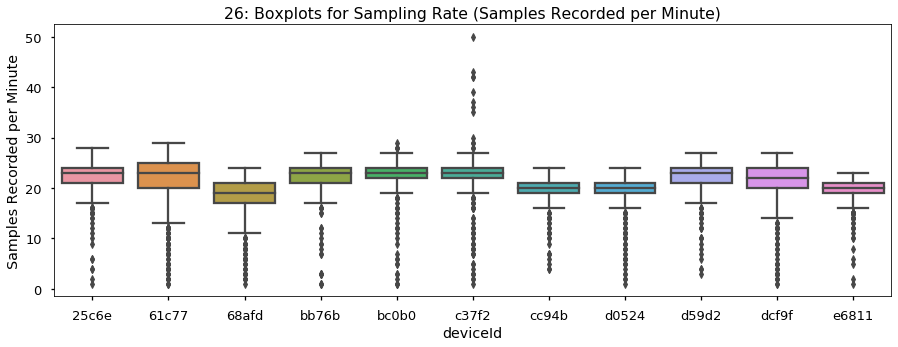

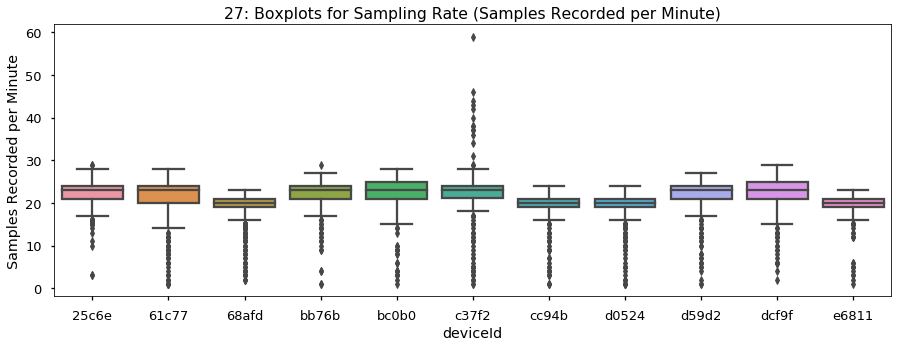

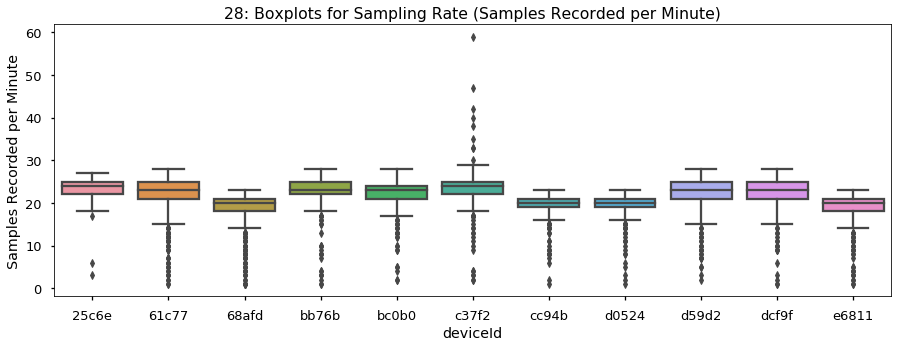

In [24]:
plot_plotwise("ds_1",23,28)

In [30]:
sub.describe()

AttributeError: 'int' object has no attribute 'describe'

           count       mean       std  min   25%   50%    75%   max
deviceId                                                           
25c6e      666.0  21.977477  3.332831  1.0  21.0  23.0  24.00  28.0
36345       41.0  14.707317  5.464631  2.0  13.0  16.0  19.00  22.0
61c77      811.0  22.643650  4.338176  1.0  22.0  23.0  25.00  29.0
68afd      971.0  17.835221  4.542541  1.0  17.0  20.0  20.00  23.0
bb76b      706.0  22.024079  3.199865  1.0  21.0  23.0  24.00  27.0
bc0b0      989.0  23.004044  3.326069  1.0  22.0  23.0  25.00  29.0
c37f2     1034.0  23.611219  4.463221  2.0  22.0  24.0  25.75  62.0
cc94b      851.0  19.823737  2.673082  1.0  20.0  20.0  21.00  24.0
d0524      571.0  18.786340  4.545662  1.0  18.0  20.0  21.00  23.0
d59d2      779.0  22.465982  2.734585  1.0  21.0  23.0  24.00  28.0
dcf9f      406.0  21.918719  4.889474  1.0  21.0  23.0  25.00  29.0
e6811      357.0  19.921569  2.419376  1.0  19.0  20.0  21.00  24.0
f0aa8      312.0  24.996795  2.960076  3.0  24.0

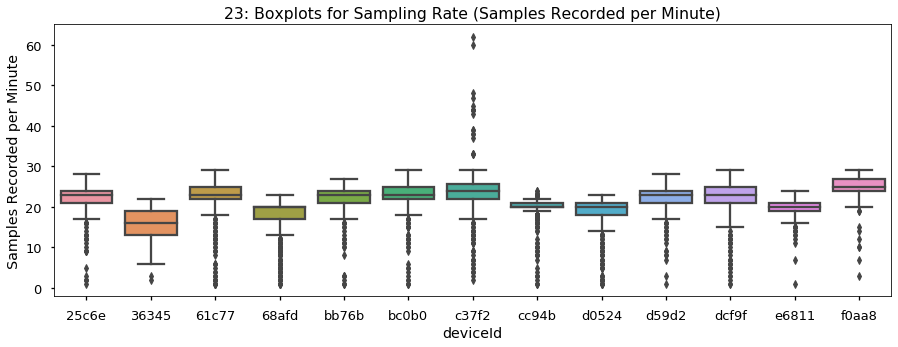

           count       mean       std  min   25%   50%   75%   max
deviceId                                                          
25c6e      615.0  21.082927  4.568475  1.0  20.0  22.0  24.0  28.0
61c77      501.0  18.111776  7.022213  1.0  14.0  21.0  23.0  27.0
68afd      830.0  18.324096  4.365096  1.0  18.0  20.0  21.0  24.0
bb76b      681.0  22.099853  3.071503  1.0  21.0  23.0  24.0  28.0
bc0b0      867.0  22.312572  2.803473  1.0  21.0  22.0  24.0  28.0
c37f2      724.0  23.232044  4.156851  1.0  22.0  24.0  25.0  64.0
cc94b      654.0  19.299694  3.105905  2.0  19.0  20.0  21.0  24.0
d0524      732.0  19.094262  3.992554  1.0  19.0  20.0  21.0  24.0
d59d2      835.0  23.215569  2.463449  3.0  22.0  24.0  25.0  28.0
dcf9f      469.0  22.232409  3.914052  1.0  22.0  23.0  24.0  28.0
e6811     1066.0  19.005629  2.768360  2.0  18.0  20.0  21.0  23.0


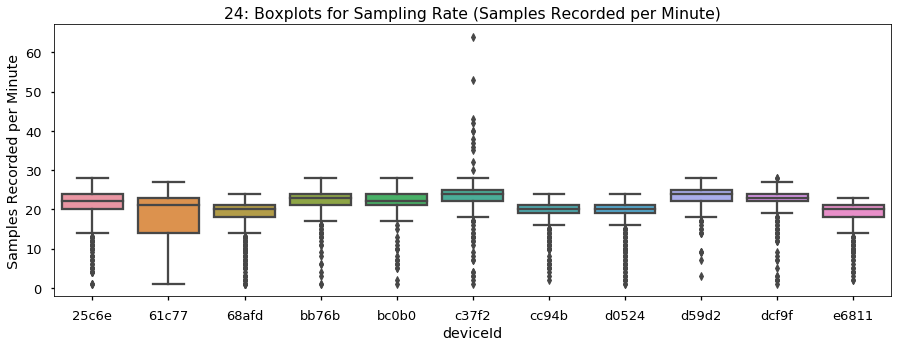

           count       mean       std  min   25%   50%   75%   max
deviceId                                                          
25c6e      976.0  22.115779  3.091414  1.0  21.0  23.0  24.0  28.0
61c77      759.0  21.316206  5.105498  1.0  21.0  23.0  24.0  28.0
68afd      959.0  19.160584  3.508307  1.0  19.0  20.0  21.0  23.0
bb76b      573.0  22.242583  3.336407  1.0  21.0  23.0  24.0  28.0
bc0b0      620.0  22.153226  3.280737  2.0  21.0  23.0  24.0  27.0
c37f2      881.0  22.514188  3.161212  2.0  22.0  23.0  24.0  31.0
cc94b      427.0  19.236534  3.018375  1.0  20.0  20.0  20.0  23.0
d0524      568.0  19.014085  4.060366  1.0  19.0  20.0  21.0  23.0
d59d2      733.0  22.465211  3.706876  1.0  22.0  23.0  24.0  28.0
dcf9f      161.0  16.391304  7.490138  1.0  11.0  19.0  23.0  27.0
e6811     1111.0  19.368137  2.611898  1.0  19.0  20.0  21.0  24.0


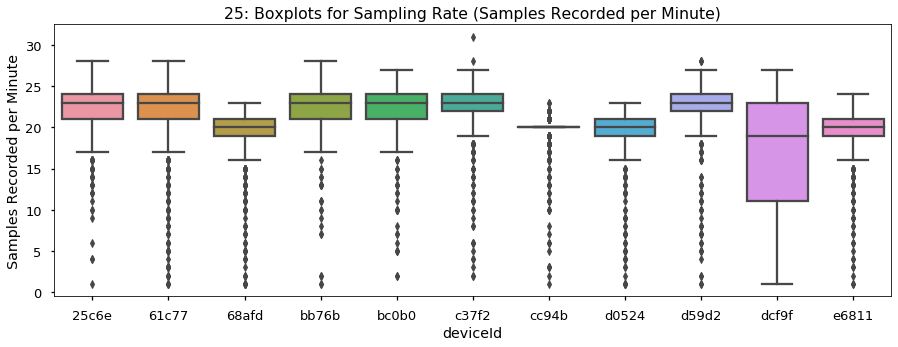

           count       mean       std  min   25%   50%   75%   max
deviceId                                                          
25c6e      692.0  22.109827  3.291803  1.0  21.0  23.0  24.0  28.0
61c77      730.0  20.820548  5.774630  1.0  20.0  23.0  25.0  29.0
68afd      775.0  18.273548  3.979276  1.0  17.0  19.0  21.0  24.0
bb76b      851.0  22.360752  3.017644  1.0  21.0  23.0  24.0  27.0
bc0b0      780.0  22.583333  3.237216  1.0  22.0  23.0  24.0  29.0
c37f2      765.0  22.545098  4.117339  1.0  22.0  23.0  24.0  50.0
cc94b      661.0  19.770045  2.398562  4.0  19.0  20.0  21.0  24.0
d0524      654.0  19.347095  3.419207  1.0  19.0  20.0  21.0  24.0
d59d2      682.0  22.209677  2.988233  3.0  21.0  23.0  24.0  27.0
dcf9f      441.0  20.736961  5.241332  1.0  20.0  22.0  24.0  27.0
e6811     1086.0  19.505525  1.965947  1.0  19.0  20.0  21.0  23.0


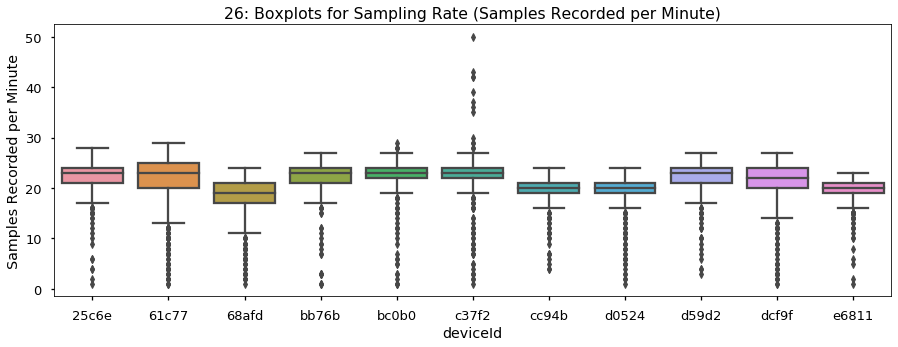

           count       mean       std  min    25%   50%   75%   max
deviceId                                                           
25c6e     1070.0  22.541121  2.674708  3.0  21.00  23.0  24.0  29.0
61c77      651.0  21.362519  4.907207  1.0  20.00  23.0  24.0  28.0
68afd     1365.0  19.498168  3.067573  2.0  19.00  20.0  21.0  23.0
bb76b     1174.0  22.444634  2.635889  1.0  21.00  23.0  24.0  29.0
bc0b0      680.0  22.426471  3.700560  1.0  21.00  23.0  25.0  28.0
c37f2     1154.0  22.645581  4.003256  1.0  21.25  23.0  24.0  59.0
cc94b      685.0  19.710949  3.088076  1.0  19.00  20.0  21.0  24.0
d0524      626.0  19.132588  3.713326  1.0  19.00  20.0  21.0  24.0
d59d2      727.0  22.254470  3.446147  1.0  21.00  23.0  24.0  27.0
dcf9f      354.0  21.980226  4.379602  2.0  21.00  23.0  25.0  29.0
e6811      561.0  19.506239  2.699282  1.0  19.00  20.0  21.0  23.0


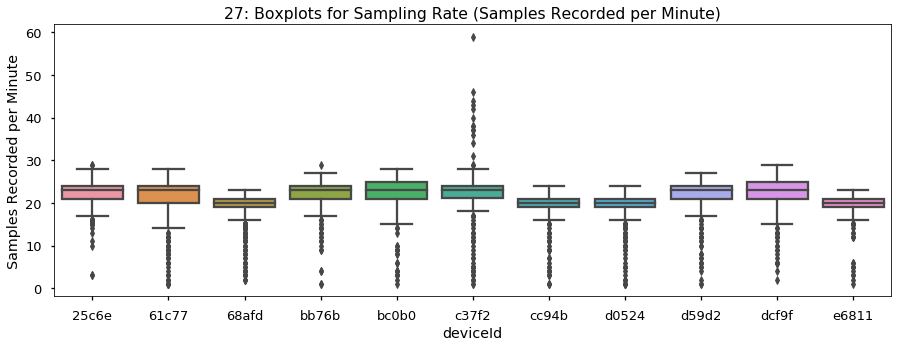

           count       mean       std  min   25%   50%   75%   max
deviceId                                                          
25c6e      111.0  23.342342  3.361535  3.0  22.0  24.0  25.0  27.0
61c77      557.0  21.718133  4.812444  1.0  21.0  23.0  25.0  28.0
68afd      703.0  18.755334  4.148236  1.0  18.0  20.0  21.0  23.0
bb76b      957.0  22.997910  3.098453  1.0  22.0  23.0  25.0  28.0
bc0b0      867.0  22.463668  2.900109  2.0  21.0  23.0  24.0  28.0
c37f2      940.0  23.323404  3.392921  2.0  22.0  24.0  25.0  59.0
cc94b      656.0  19.657012  2.341079  1.0  19.0  20.0  21.0  23.0
d0524      576.0  19.701389  2.560108  1.0  19.0  20.0  21.0  23.0
d59d2      893.0  22.613662  3.335116  2.0  21.0  23.0  25.0  28.0
dcf9f      335.0  22.259701  4.108705  1.0  21.0  23.0  25.0  28.0
e6811     1004.0  19.172311  2.830046  1.0  18.0  20.0  21.0  23.0


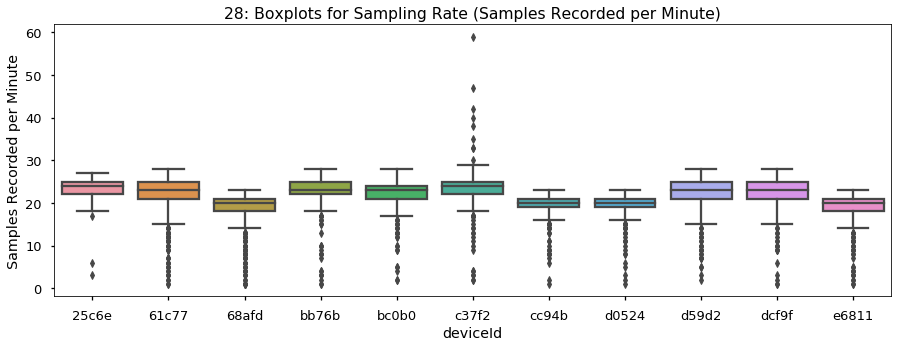

           count       mean       std   min    25%   50%   75%   max
deviceId                                                            
25c6e       30.0  17.666667  6.899942   1.0  12.25  21.0  23.0  26.0
36345      445.0  16.382022  5.481553   1.0  14.00  18.0  20.0  23.0
61c77      771.0  21.518807  5.288861   1.0  20.00  23.0  25.0  28.0
68afd     1015.0  18.989163  3.747567   1.0  18.00  20.0  21.0  23.0
bb76b     1011.0  22.929773  3.133027   2.0  22.00  23.0  25.0  29.0
bc0b0      777.0  23.214929  3.014806   1.0  22.00  24.0  25.0  28.0
c37f2      939.0  23.113951  3.825736   2.0  22.00  23.0  25.0  65.0
cc94b      702.0  19.786325  2.507606   1.0  19.00  20.0  21.0  23.0
d0524      731.0  18.938440  3.998669   1.0  19.00  20.0  21.0  23.0
d59d2       21.0  24.095238  0.943650  23.0  23.00  24.0  25.0  26.0
dcf9f      503.0  21.948310  4.471391   1.0  21.00  23.0  25.0  28.0
e6811      401.0  19.443890  2.110087   1.0  19.00  20.0  21.0  23.0
f0aa8     1143.0  23.115486  2.659

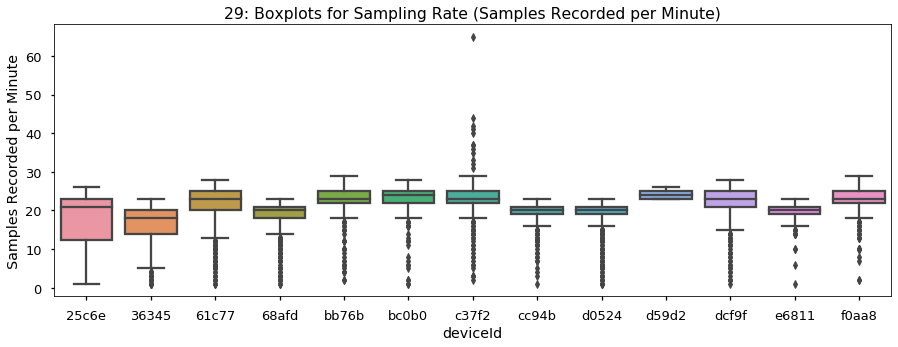

           count       mean       std  min    25%   50%   75%   max
deviceId                                                           
61c77      947.0  21.484688  5.286959  1.0  21.00  23.0  25.0  28.0
68afd      855.0  18.695906  3.984004  1.0  18.00  20.0  21.0  23.0
bb76b      509.0  22.813360  3.135167  4.0  22.00  23.0  25.0  28.0
bc0b0      963.0  22.322949  2.808615  3.0  21.00  23.0  24.0  28.0
c37f2      906.0  23.067329  4.174494  1.0  22.00  23.0  25.0  52.0
cc94b      610.0  19.206557  3.405775  1.0  19.00  20.0  21.0  23.0
d0524      797.0  19.232120  3.502701  1.0  19.00  20.0  21.0  23.0
d59d2      543.0  22.410681  3.333664  1.0  21.00  23.0  25.0  28.0
dcf9f      344.0  19.284884  6.473557  1.0  16.75  22.0  24.0  29.0
e6811      674.0  18.780415  3.165917  1.0  18.00  20.0  21.0  23.0
f0aa8     1251.0  22.632294  3.398218  1.0  22.00  23.0  25.0  28.0


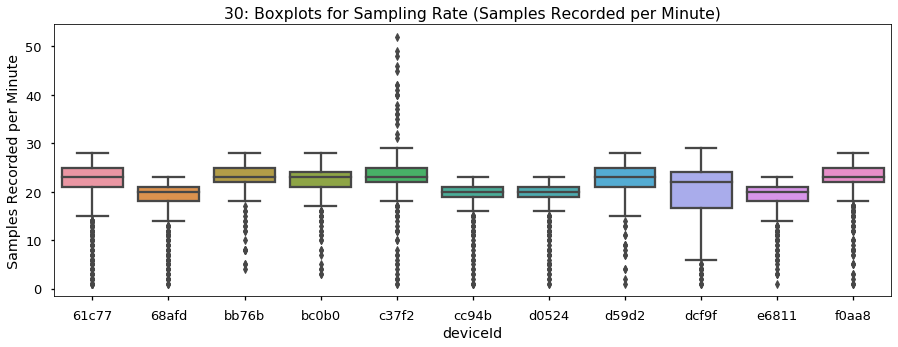

In [63]:
result = plot_plotwise("ds_1",23,30)

In [64]:
print(result[0])
dist_medians = []
dist_75 = []
dist_25 = []
for df in result:
#     print(df.size())
    for i in range(len(df)):
#         print(df.iloc[i]['50%'])
        dist_medians.append(df.iloc[i]['50%'])
        dist_75.append(df.iloc[i]['75%'])
        dist_25.append(df.iloc[i]['25%'])
#     print('dome')

print(dist_medians)
stats =  {'medians': dist_medians, 
        '25th': dist_25, '75th' : dist_75}  
stats = pd.DataFrame.from_dict(stats) 
print(stats.describe())
        

           count       mean       std  min   25%   50%    75%   max
deviceId                                                           
25c6e      666.0  21.977477  3.332831  1.0  21.0  23.0  24.00  28.0
36345       41.0  14.707317  5.464631  2.0  13.0  16.0  19.00  22.0
61c77      811.0  22.643650  4.338176  1.0  22.0  23.0  25.00  29.0
68afd      971.0  17.835221  4.542541  1.0  17.0  20.0  20.00  23.0
bb76b      706.0  22.024079  3.199865  1.0  21.0  23.0  24.00  27.0
bc0b0      989.0  23.004044  3.326069  1.0  22.0  23.0  25.00  29.0
c37f2     1034.0  23.611219  4.463221  2.0  22.0  24.0  25.75  62.0
cc94b      851.0  19.823737  2.673082  1.0  20.0  20.0  21.00  24.0
d0524      571.0  18.786340  4.545662  1.0  18.0  20.0  21.00  23.0
d59d2      779.0  22.465982  2.734585  1.0  21.0  23.0  24.00  28.0
dcf9f      406.0  21.918719  4.889474  1.0  21.0  23.0  25.00  29.0
e6811      357.0  19.921569  2.419376  1.0  19.0  20.0  21.00  24.0
f0aa8      312.0  24.996795  2.960076  3.0  24.0

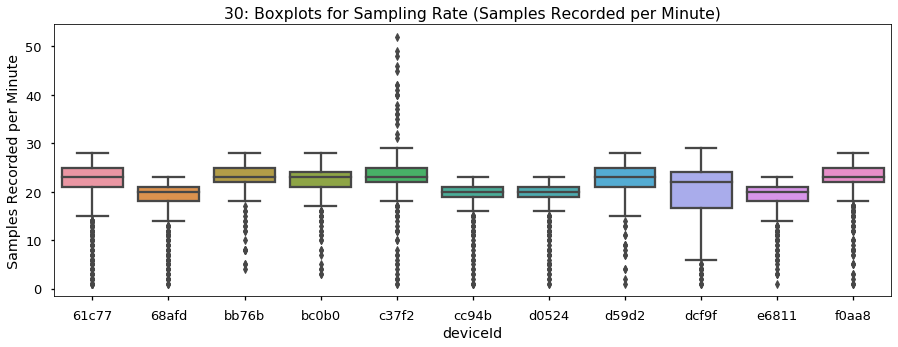

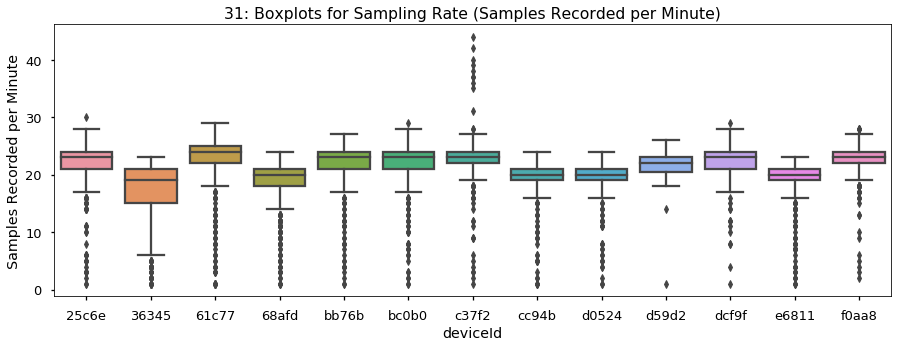

In [15]:
plot_plotwise("ds_1")

2) Distribution of Number of Minutes each Device was Active in an Hour

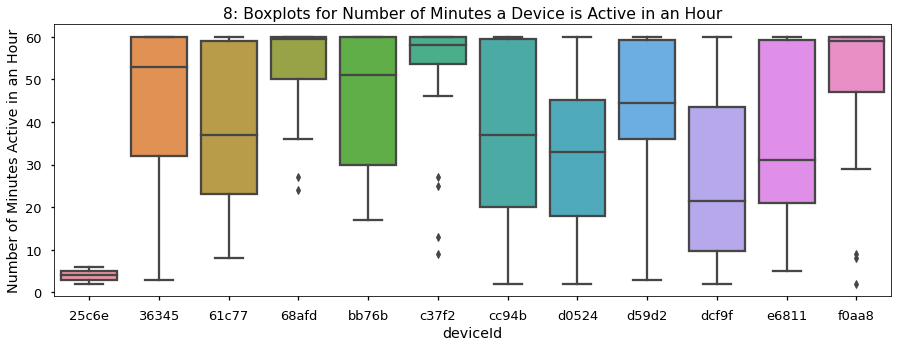

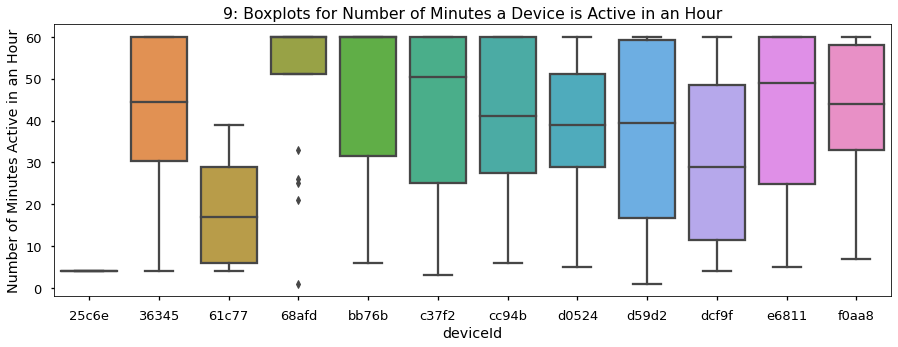

In [7]:
plot_plotwise("ds_2")

3) Aggregated Distribution of Number of Recordings per Minute

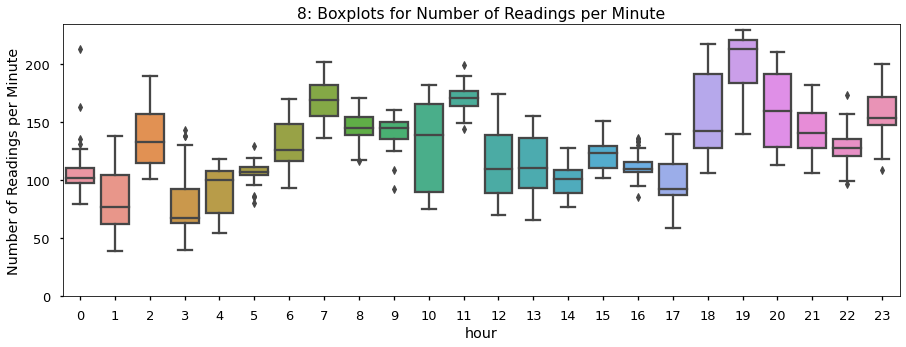

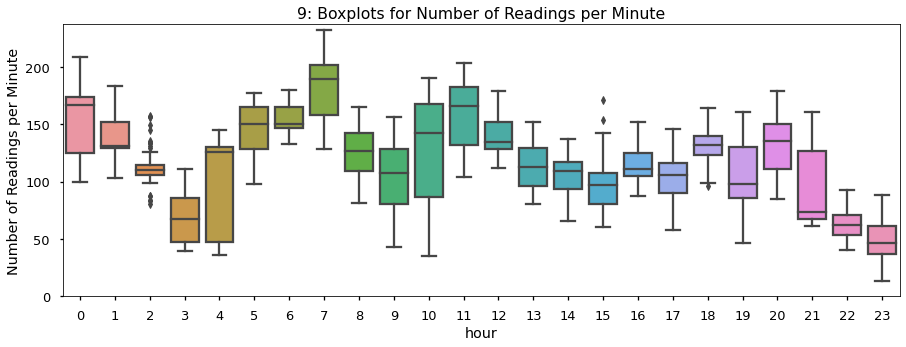

In [8]:
plot_plotwise("ds_3")

4) Aggregated Total Number of Readings per Minute

In [9]:
# plot_plotwise("ds_4")

5) Number of Hours each Device was Active

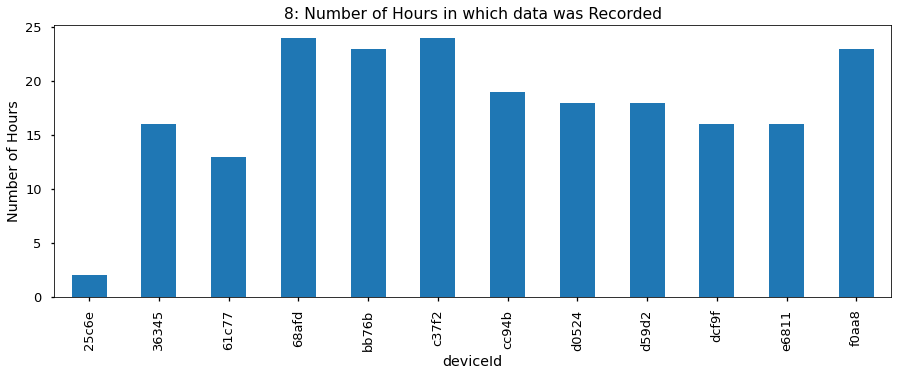

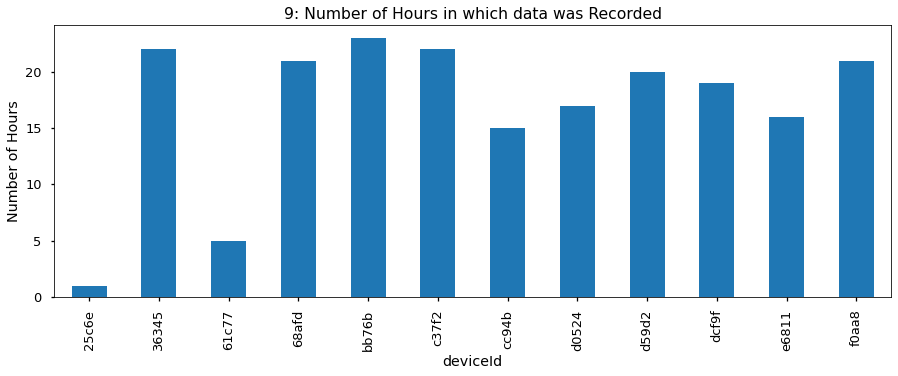

In [10]:
plot_plotwise("ds_5")

#### Spatial Metrics

1. Proportion of Points with Invalid Coordinates (lat or long <=1)

In [14]:
# plot_plotwise("s_1")

#### Location and Time Metric
1. Distribution of Regions with Hours

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


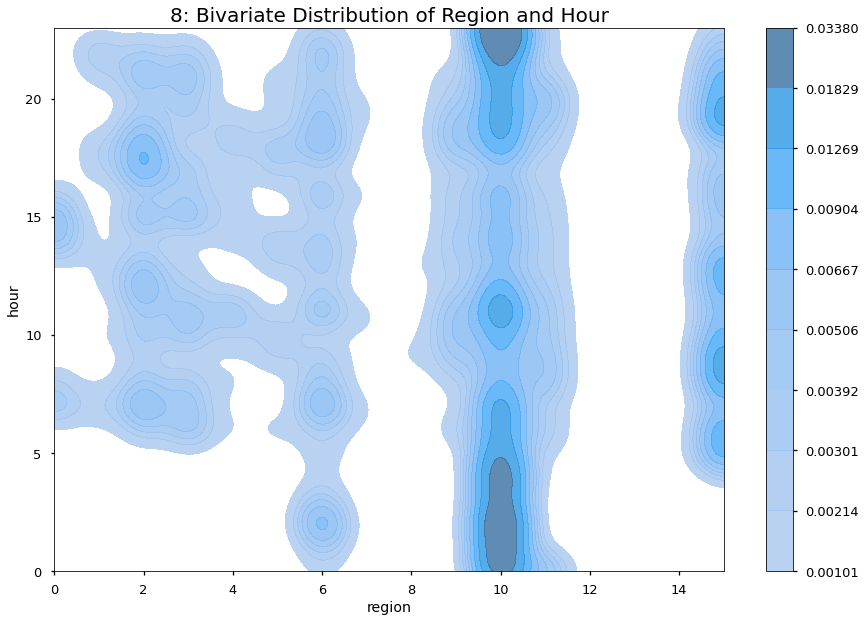

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


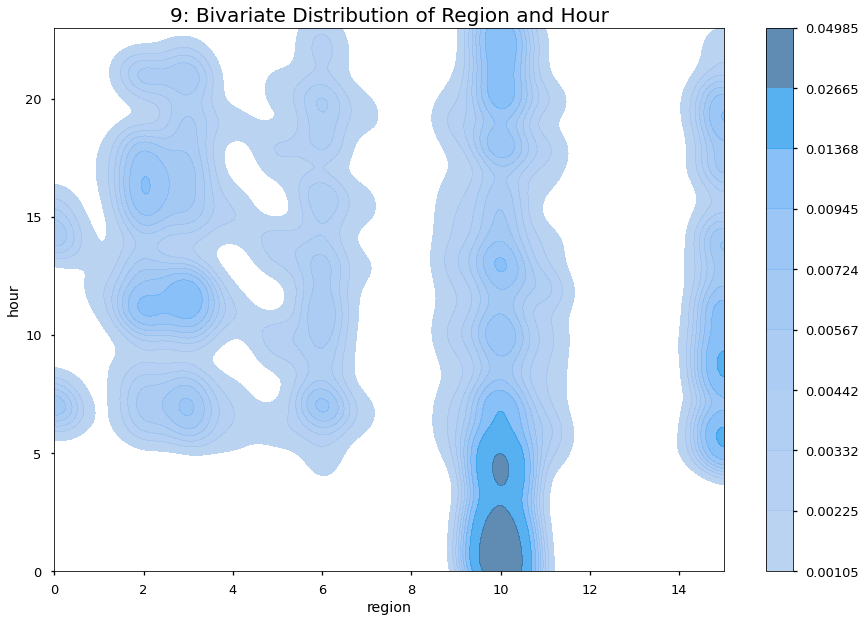

In [11]:
plot_plotwise("l_t")

#### PM Metric
1) Intra-Sensor Distribution of PM 2.5 Values at Depot

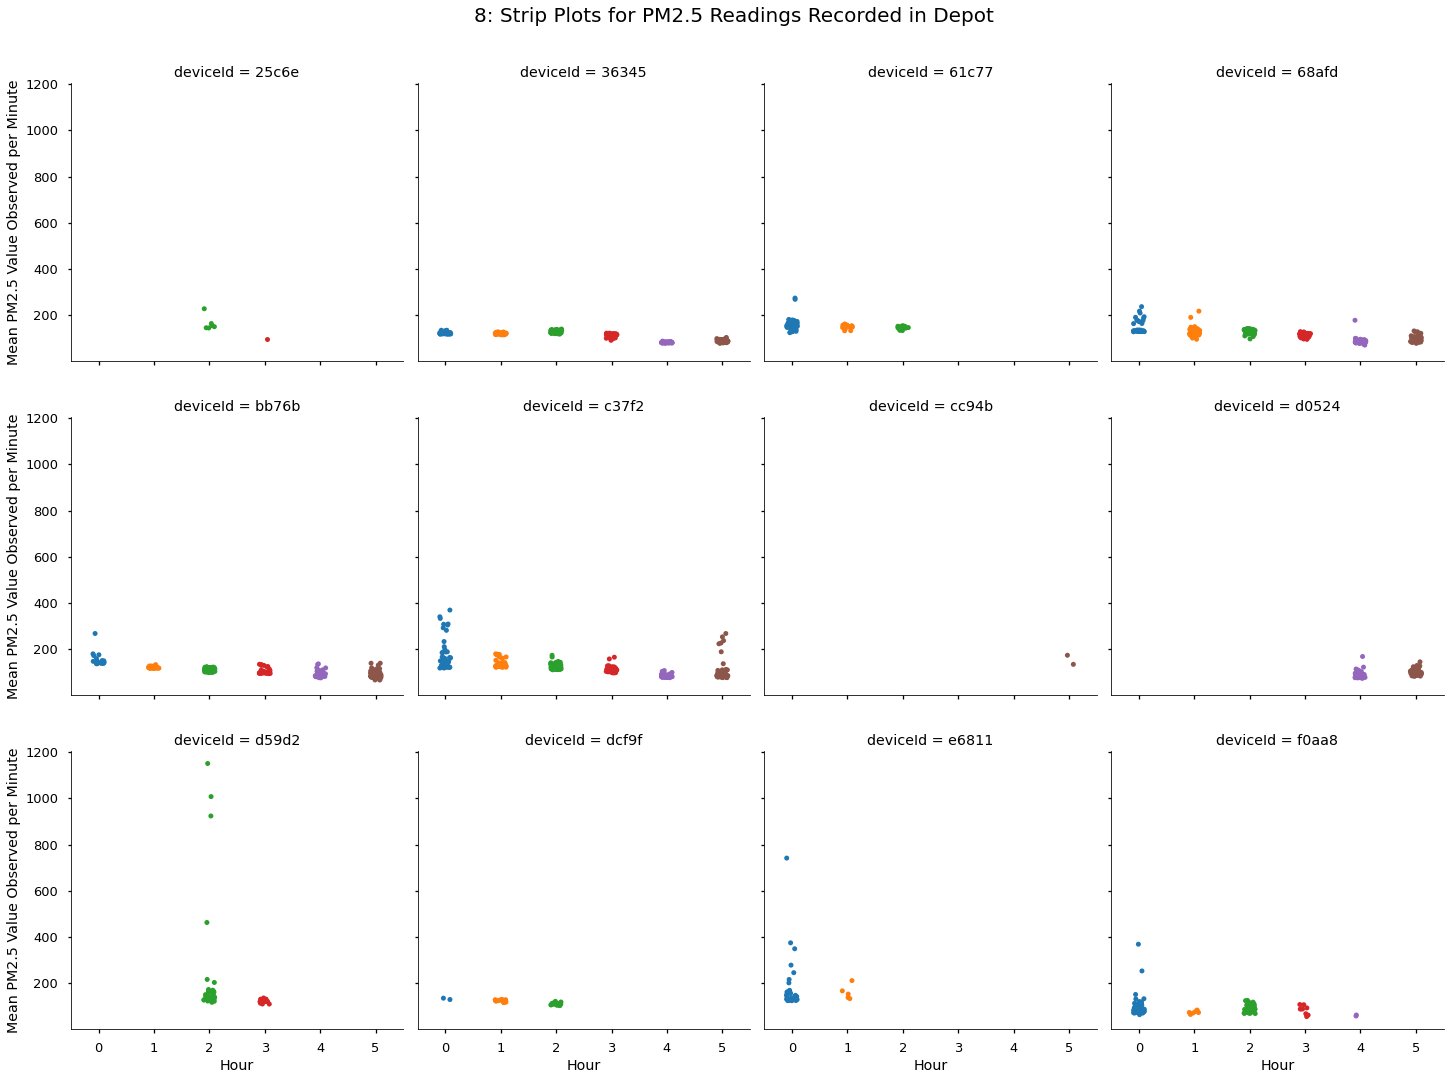

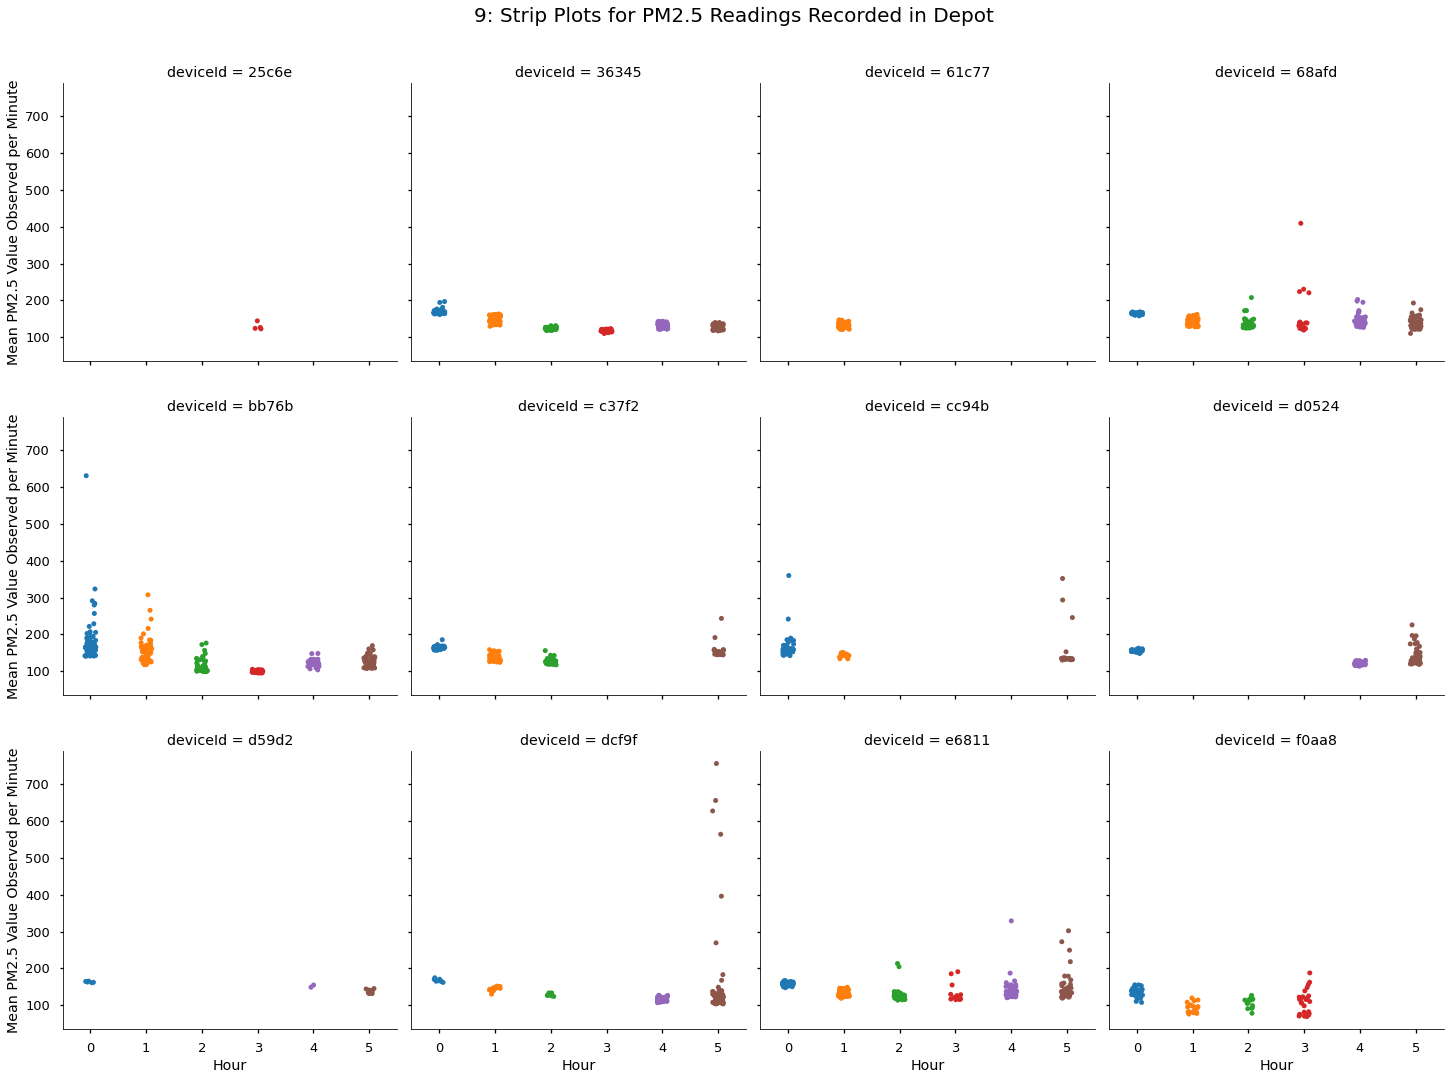

In [12]:
plot_plotwise("pm_1")

2)  Inter-Sensor Distribution of PM 2.5  Values at Depot

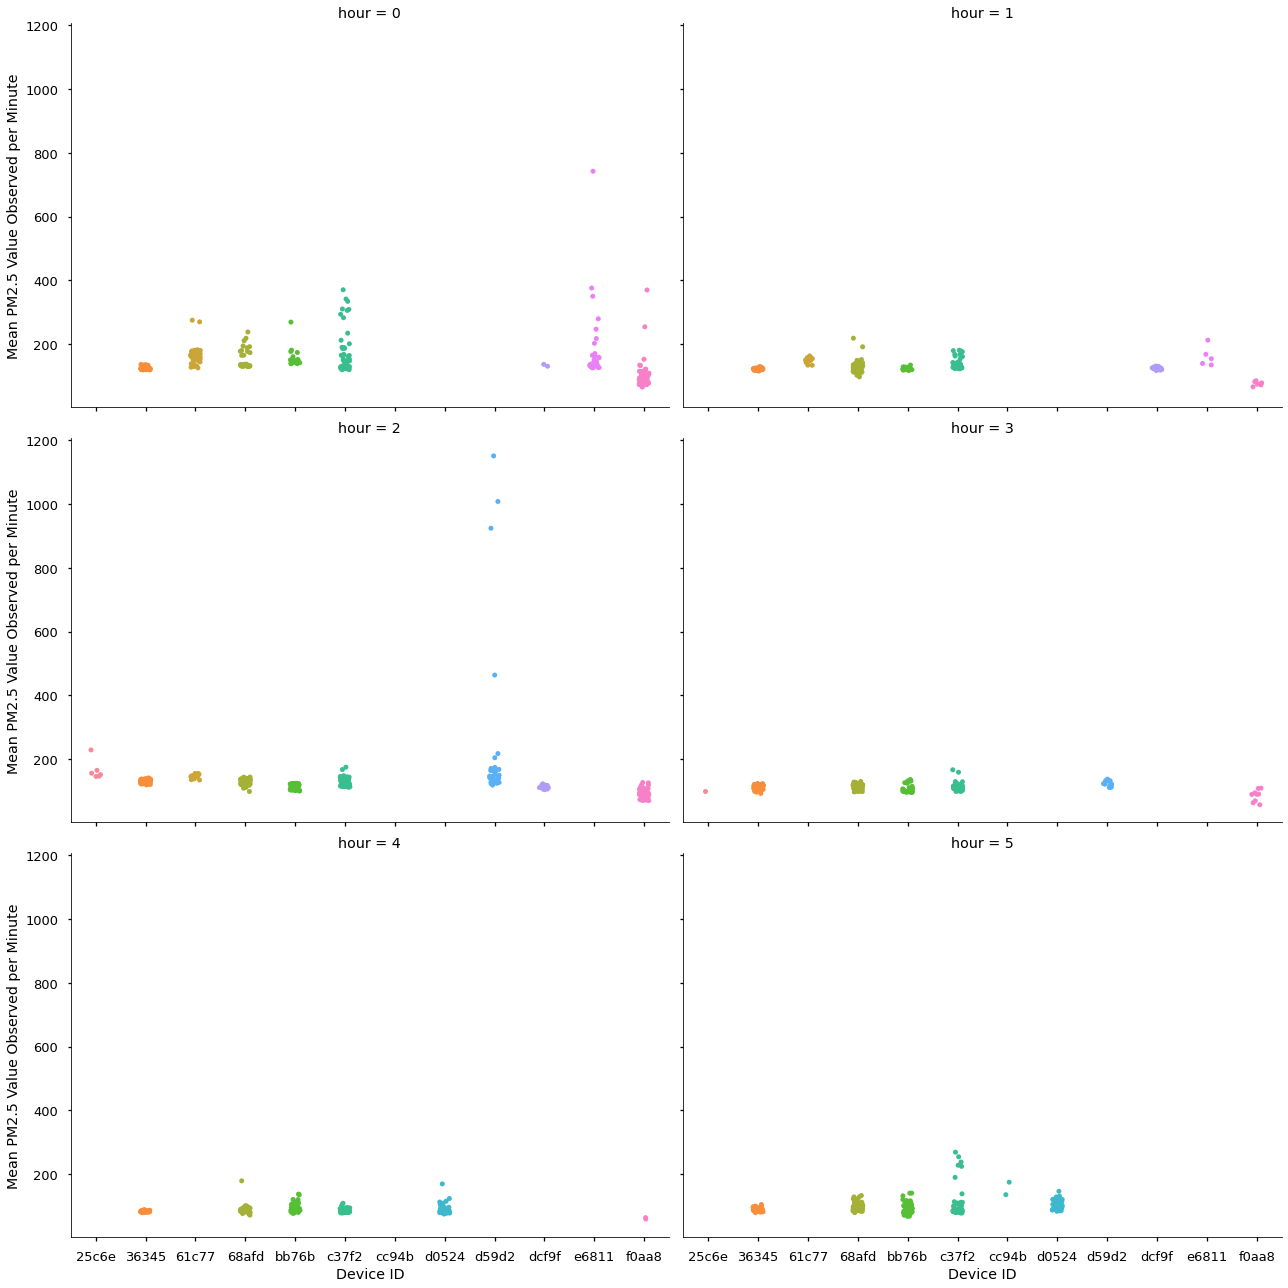

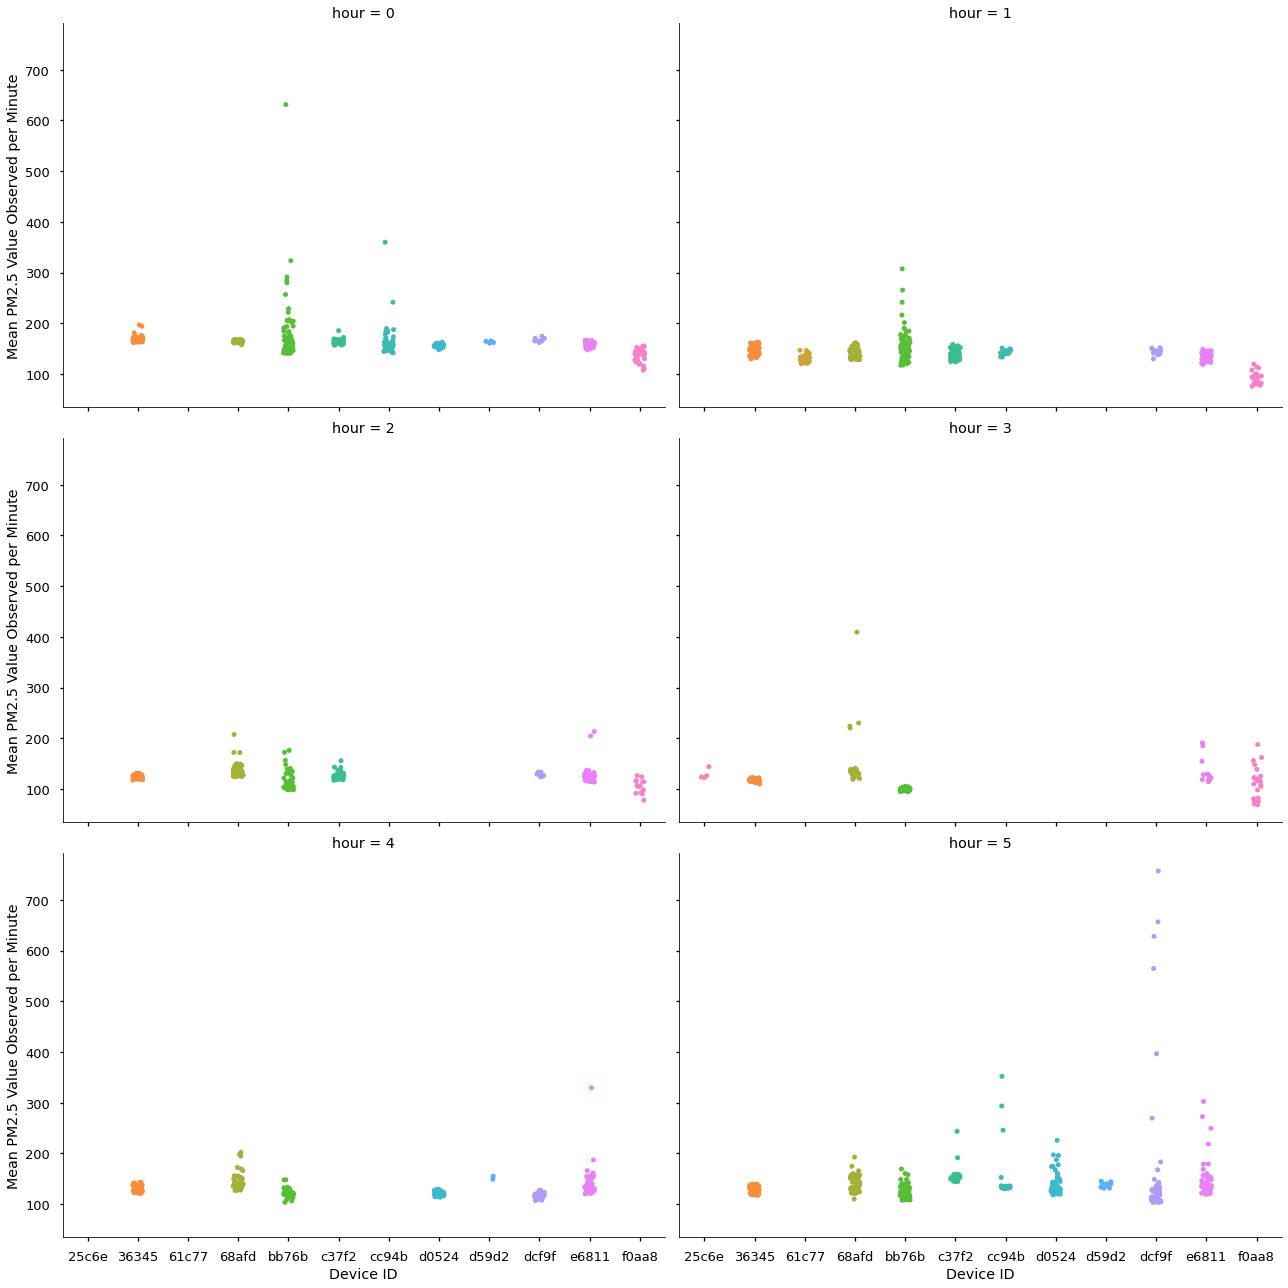

In [13]:
plot_plotwise("pm_2")

-----

# Leave The Below

### Sanity Check: SPC

In [9]:
ds_means = np.empty((1,4))
ds_means = pd.DataFrame(ds_means, columns= ["date", "deviceId", "mean", "std"])

for day_int in range(13, 15):
    dt = "2020-11-" + str(day_int)
    print(dt)
    df_bme, df_gps, df_pol = read_raw(dt)
    df_all = preprocess((df_bme, df_gps, df_pol))
    
    df_all = df_all[(df_all.hour > 6) & (df_all.hour < 21)]
    
    sensor_order = df_all.deviceId.unique()
    sensor_order.sort()
    
    sampling_rates = df_all.groupby(["deviceId", "hour", "minute"]).size().reset_index()
    metrics = sampling_rates.groupby(["deviceId"]).agg(["mean", "std"])
    
    metrics = metrics[0].reset_index()
    metrics["date"] = dt
    
    ds_means = pd.concat([ds_means, metrics], axis=0)
    print("--*--")
    
ds_means = ds_means.iloc[1:, :]
ds_means.columns = ["date", "deviceid", "means", "deviations"]
ds_means.reset_index(drop = True, inplace= True)

2020-11-13
--*--
2020-11-14
--*--


<AxesSubplot:xlabel='0', ylabel='Density'>

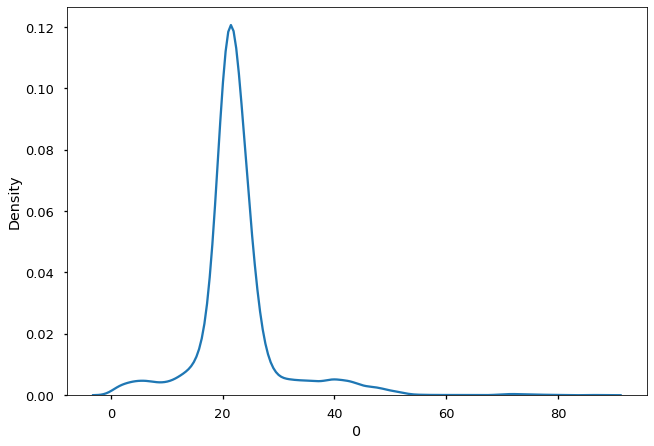

In [10]:
sns.kdeplot(sampling_rates[0])

In [11]:
grand_mean = ds_means["means"].mean()

In [51]:
v1 = sampling_rates[sampling_rates.deviceId == sensor_order[0]][0].values
v2 = sampling_rates[sampling_rates.deviceId == sensor_order[6]][0].values
print(sensor_order[0], sensor_order[6])

36345 e6811


In [13]:
se = ds_means["deviations"].mean()/0.9896

In [15]:
ucl = grand_mean + 3*se/24
lcl = grand_mean - 3*se/24

Text(0, 0.5, 'Sampling per hour Rate')

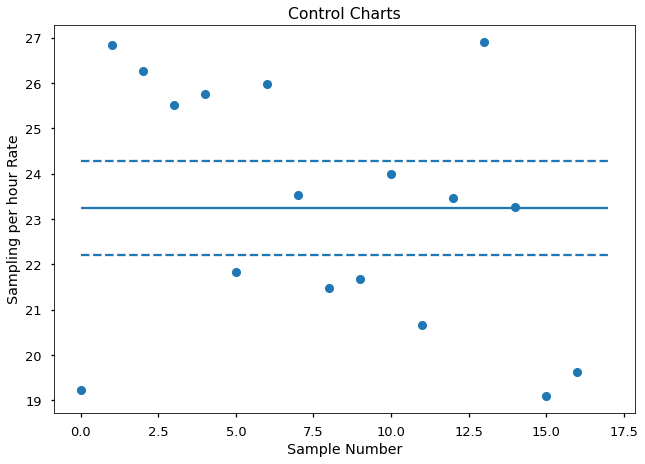

In [16]:
ds_means["means"].plot(style= "o")
plt.hlines(y =ucl , xmin = 0 , xmax = ds_means.shape[0], linestyles = "--")
plt.hlines(y =lcl , xmin = 0 , xmax = ds_means.shape[0], linestyles = "--")
plt.hlines(y =grand_mean , xmin = 0 , xmax = ds_means.shape[0])
plt.title("Control Charts")
plt.xlabel("Sample Number")
plt.ylabel("Sampling per hour Rate")

In [37]:
from scipy.stats import ttest_ind

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import epps_singleton_2samp

In [60]:
epps_singleton_2samp(v1, v1)

Epps_Singleton_2sampResult(statistic=11.391671686496295, pvalue=0.02249752387100167)

In [36]:
mannwhitneyu(v1, v1 + 0.00000000000000000005)

MannwhitneyuResult(statistic=282000.5, pvalue=0.4999759257457436)

In [28]:
shapiro(v2)

ShapiroResult(statistic=0.7866449356079102, pvalue=1.91096155197217e-31)

In [24]:
ttest_ind(v1, v2)

Ttest_indResult(statistic=-7.515368361836895, pvalue=9.479114449378766e-14)